# Computed Tomography Simulator

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.util import img_as_int
import pydicom
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
import datetime
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from pydicom.data import get_testdata_file
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex
import functools
from IPython.core.display import display, HTML
from PIL import Image, ImageOps

In [2]:
def calculateRMSE(input_img, output_img):
    if np.amax(output_img) > 1:
        output_img = output_img / 255
    if np.amax(input_img) > 1:
        input_img = np.array(input_img) / 255
    print(np.amin(input_img), np.amax(input_img))
    print(np.amin(output_img), np.amax(output_img))
    rmse = 0.0
    n = input_img.shape[0] * input_img.shape[1]
    rmse = np.sum(np.concatenate((input_img - output_img)**2))       
    return np.sqrt(rmse / n)

In [3]:
def write_as_dcm(img, filename, firstName, lastName, patientID, sex, birthDate, studyDate, comment):
    img = img_as_int(img)
    filect = get_testdata_file('CT_small.dcm')
    ds = pydicom.dcmread(filect)
    
    ds.PatientName = '{}^{}'.format(lastName, firstName)
    ds.PatientID = patientID
    ds.PatientSex = sex
    ds.PatientBirthDate = birthDate
    ds.StudyDate = studyDate
    
    ds.Rows, ds.Columns = img.shape[0], img.shape[1]
    ds.PixelRepresentation = 0
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelData = img.tobytes()
    ds.ImageComments = comment
    
    ds.save_as(filename)

In [4]:
class Radon():
    def __init__(self, step_alpha: float = 2, num_detectors: int = 120, detectors_range: int = 120, 
                 is_filtered: bool = True, is_animated: bool = False):
        self.height = None
        self.width = None
        self.step_alpha = step_alpha
        self.num_detectors = num_detectors
        self.detectors_range = np.deg2rad(detectors_range)  # angle
        self.ok = 0
        self.nook = 0
        self.kernel = None
        self.is_filtered = is_filtered
        self.ds = None
        self.img = None
        self.is_animated = is_animated

    def load_photo(self, img_name):
        if img_name.endswith(".dcm"):
            self.ds = pydicom.dcmread(img_name)
            self.img = self.ds.pixel_array
        else:
            self.img = cv2.imread(img_name, 0)
        self.add_padding()

    def set_step_alpha(self, value: int):
        self.step_alpha = value

    def set_num_detectors(self, value: int):
        self.num_detectors = value

    def set_detectors_range(self, value: int):
        self.detectors_range = value
        
    def set_is_animated(self, value: bool):
        self.is_animated = value

    def add_padding(self):
        self.height, self.width, *args = self.img.shape
        if self.height > self.width:
            diff = (self.height - self.width)
            left = diff // 2
            right = diff // 2
            if diff % 2 != 0:
                left += 1
            self.img = cv2.copyMakeBorder(self.img, 0, 0, left, right, cv2.BORDER_CONSTANT)
        elif self.width > self.height:
            diff = (self.width - self.height)
            top = diff // 2
            bottom = diff // 2
            if diff % 2 != 0:
                top += 1
            self.img = cv2.copyMakeBorder(self.img, top, bottom, 0, 0, cv2.BORDER_CONSTANT)

    def get_sinogram(self):
        sinogram = np.zeros((int(360//self.step_alpha), self.num_detectors))
        angles = np.arange(0., 360., self.step_alpha)
        
        animation = []
        
        for i, angle_emitter in enumerate(angles):
            positions_emitter, positions_detectors = self.get_positions(angle_emitter)
            pixels_color = self.get_pixels_color(positions_emitter, positions_detectors)
            sinogram[i] = pixels_color
            
            if self.is_animated:
                out_animation = sinogram.copy()
                out_animation = np.array(self.normalizeArray(out_animation, int(360//self.step_alpha), self.num_detectors))
                img = Image.fromarray(out_animation * 255)
                animation.append(img)
                
        if self.is_animated:
            animation[0].save('sinogram.gif', save_all = True, append_images = animation[1:])
                
        return sinogram

    def get_positions(self, angle_emitter):
        angle_emitter = np.deg2rad(angle_emitter)  # change degree to radian
        positions_detectors = []
        r = self.img.shape[0] * np.sqrt(2) / 2  # radius of circle
        center = int(self.img.shape[0] / 2)
        positions_emitter = [int(r * np.cos(angle_emitter)) + center,
                             int(r * np.sin(angle_emitter)) + center]
        if self.num_detectors > 1:
            for i in range(self.num_detectors):
                position = [
                    int(r * np.cos(angle_emitter + np.pi - self.detectors_range / 2 + i * self.detectors_range / (
                                self.num_detectors - 1))) + center,
                    int(r * np.sin(angle_emitter + np.pi - self.detectors_range / 2 + i * self.detectors_range / (
                                self.num_detectors - 1))) + center]
                positions_detectors.append(position)

        return positions_emitter, positions_detectors

    def bresenham_line(self, start, end):
        start_x, start_y = int(start[0]), int(start[1])
        end_x, end_y = int(end[0]), int(end[1])

        kx = 1 if start_x <= end_x else -1
        ky = 1 if start_y <= end_y else -1

        dx = abs(start_x - end_x)
        dy = abs(start_y - end_y)

        yield start_x, start_y

        if dx < dy:
            e = dy / 2
            for i in range(int(dy)):
                start_y += ky
                e = e - dx
                if e < 0:
                    start_x += kx
                    e = e + dy
                yield start_x, start_y
        else:
            e = dx / 2
            for i in range(int(dx)):
                start_x += kx
                e = e - dy
                if e < 0:
                    start_y += ky
                    e += dx
                yield start_x, start_y

    def point_in_picture(self, x, y):
        if (0 <= x < self.img.shape[0]) and (0 <= y < self.img.shape[0]):
            return True
        else:
            return False

    def get_pixels_color(self, emitter_position, detectors_position):
        colors = []
        for detector_position in detectors_position:
            color = 0.0
            count_pixels = 0
            for x, y in self.bresenham_line(emitter_position, detector_position):
                if self.point_in_picture(x, y):
                    color += self.img[x][y]
                    count_pixels += 1
            if count_pixels:
                tmp = color / count_pixels
                colors.append(tmp/255)
            else:
                colors.append(np.float64(0))
                
        return colors

    def normalizeVector(self, vec):
        normalizeVec = []
        rowMax = max(vec)
        rowMin = min(vec)
        diff = rowMax - rowMin
        for v in vec:
            normalizeVec.append((v-rowMin)/diff)
            
        return normalizeVec

    def normalizeArray(self, arr, x, y):
        normalizeArr = np.zeros((x, y))
        rowMax = 0
        rowMin = 999999
        for row in arr:
            if max(row) > rowMax:
                rowMax = max(row)
            if min(row) < rowMin:
                rowMin = min(row)
        diff = rowMax - rowMin
        for i, row in enumerate(arr):
            for j, x in enumerate(row):
                x -= rowMin
                x /= diff if diff > 0 else 0
                normalizeArr[i][j] = x
                
        return normalizeArr


    def get_inverse(self, sinogram):
        angles = np.arange(0., 360., self.step_alpha)
        output_image = np.zeros((self.img.shape[1], self.img.shape[0]))
        all_emitters = []
        all_detectors = []
        animation = []

        for angle_emitter in angles:
            positions_emitter, positions_detectors = self.get_positions(angle_emitter)
            all_emitters.append(positions_emitter)
            all_detectors.append(positions_detectors)

        for i in range(len(all_emitters)):
            for j in range(len(all_detectors[i])):
                for x, y in self.bresenham_line(all_emitters[i], all_detectors[i][j]):
                    if self.point_in_picture(x, y):
                        output_image[x][y] += sinogram[i][j]
            if self.is_animated and (i%2 == 0 or i==len(all_emitters)-1):
                out_animation = output_image.copy()
                out_animation = np.array(self.normalizeArray(out_animation, out_animation.shape[1], out_animation.shape[0]))
                img = Image.fromarray(out_animation * 255)
                animation.append(img)
        
        if self.is_animated:
            animation[0].save('reverse.gif', save_all = True, append_images = animation[1:])

        return self.normalizeArray(output_image, output_image.shape[1], output_image.shape[0])

    def create_kernel(self, size=100):
        kernel = []
        for i in range(-size//2, size//2):
            if i == 0:
                kernel.append(1)
            elif i % 2 ==0:
                kernel.append(0)
            else:
                kernel.append((-4/(np.pi**2))/(i**2))

        return kernel


    def filtruj(self, row_to_filter):
        if self.kernel is None:
            self.kernel = self.create_kernel()
            
        return np.convolve(row_to_filter, self.kernel, mode = 'same')
    
    
    def draw_sinogram(self):
        fig=plt.figure(figsize=(17,50))
        sinogram = np.array(self.get_sinogram())
        
        if self.is_filtered:
            sinogram_f = []
            for row in sinogram:
                row_f = self.filtruj(row)
                sinogram_f.append(row_f)   
            sinogram = np.array(sinogram_f)
        
        sinogram = np.array(sinogram)
        self.reverse_img = self.get_inverse(sinogram)
        
        if self.is_animated:
            f = open('sinogram.gif', 'rb')
            f = f.read()
            img = widgets.Image(value = f, width = 200)
            display(img)
            f = open('reverse.gif', 'rb')
            f = f.read()
            img = widgets.Image(value = f, width = 200)
            display(img)
        else:
            fig.add_subplot(1, 3, 1)
            plt.imshow(self.img, cmap = 'gist_gray')
            fig.add_subplot(1, 3, 2)       
            plt.imshow(sinogram, cmap = 'gist_gray')
            fig.add_subplot(1, 3, 3)
            plt.imshow(self.reverse_img, cmap = 'gist_gray')
            plt.show()

In [5]:
step_alpha = widgets.FloatSlider(
    value=1,
    min=0.5,
    max=3,
    step=0.5,
    description='Step alpha:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

num_detectors = widgets.IntSlider(
    value=120,
    min=80,
    max=720,
    step=20,
    description='Number of detectors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

detectors_range = widgets.IntSlider(
    value=180,
    min=40,
    max=360,
    step=20,
    description='Detectors range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

is_filtered = widgets.Checkbox(
    value=False,
    description='Use filter',
    disabled=False,
    indent=False
)

is_animated = widgets.Checkbox(
    value=False,
    description='Show animation',
    disabled=False,
    indent=False
)

file = widgets.FileUpload(
    accept='img\*',  
    multiple=False  
)

## Process image

FileUpload(value={}, accept='img\\*', description='Upload')

FloatSlider(value=1.0, continuous_update=False, description='Step alpha:', max=3.0, min=0.5, readout_format='.…

IntSlider(value=120, continuous_update=False, description='Number of detectors:', max=720, min=80, step=20)

IntSlider(value=180, continuous_update=False, description='Detectors range:', max=360, min=40, step=20)

Checkbox(value=False, description='Use filter', indent=False)

Checkbox(value=False, description='Show animation', indent=False)

Button(description='Start processing', style=ButtonStyle())

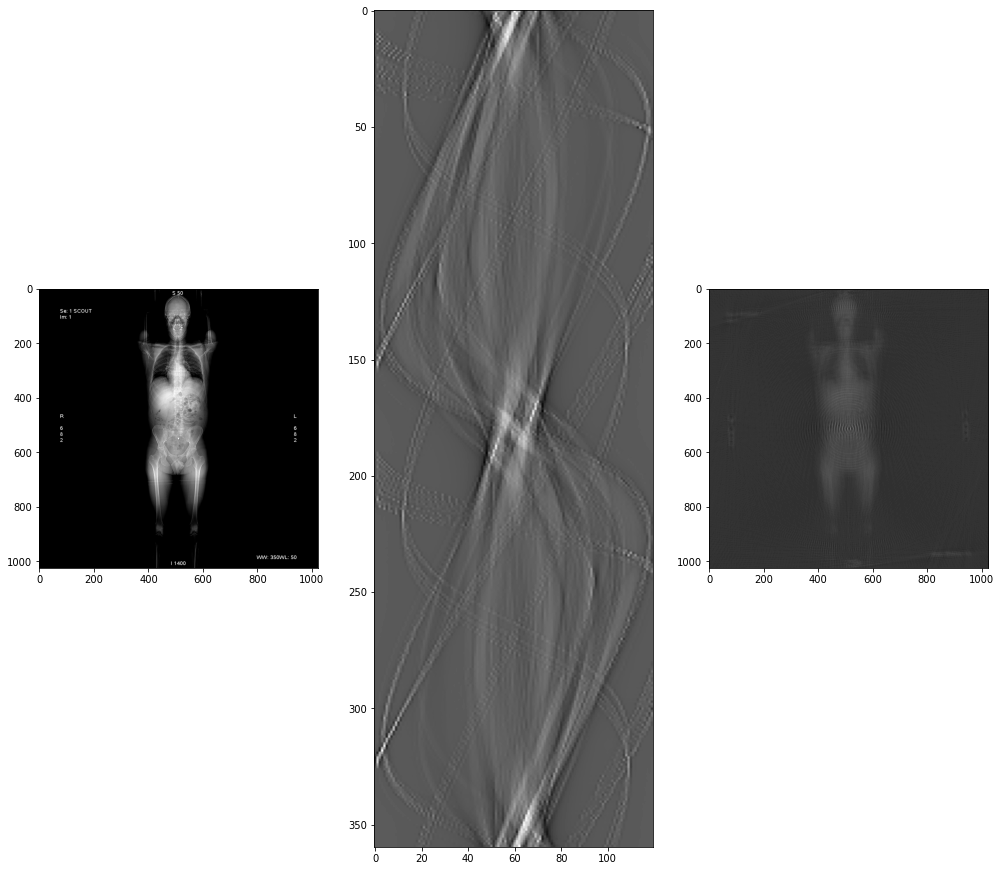

In [6]:
button = widgets.Button(description="Start processing")

def on_button_clicked(b):
    filename = list(file.value.keys())[0]
    global radon
    radon = Radon(step_alpha.value, num_detectors.value, detectors_range.value, is_filtered.value, is_animated.value)
    radon.load_photo(f'img\{filename}')
    radon.draw_sinogram()


display(Markdown('## Process image'))
display(file)
display(step_alpha)
display(num_detectors)
display(detectors_range)
display(is_filtered)
display(is_animated)
display(button)
button.on_click(on_button_clicked)



## Save image as dicom file

In [7]:

first_name = widgets.Text(
    description='First Name:',
    disabled=False
)

last_name = widgets.Text(
    description='Last Name:',
    disabled=False
)

id_patient = widgets.Text(
    description='Id :',
    disabled=False
)

sex = widgets.Dropdown(
    options=['Woman', 'Man', 'Others'],
    description='Sex: :',
    disabled=False,
)

birth_date = widgets.DatePicker(
    description='Birthday: ',
    disabled=False
)

test_date = widgets.DatePicker(
    description='Test day: ',
    disabled=False
)

comment = widgets.Textarea(
    description='Comment:',
    disabled=False
)

filename = widgets.Text(
    placeholder = 'Type filename without file extension',
    description='Filename:',
    disabled=False
)
button_save = widgets.Button(description="Save")

display(first_name)
display(last_name)
display(id_patient)
display(sex)
display(birth_date)
display(test_date)
display(comment)
display(filename)
display(button_save)

#write_as_dcm(img, f'{filename.value}.dcm', first_name.value, last_name.value, id_patient.value, sex.value, str(birth_date.value),str(test_date.value) , comment.value)

def on_save_button(b):
    write_as_dcm(radon.reverse_img,
                 filename.value,
                 first_name.value,
                 last_name.value,
                 id_patient.value,
                 sex.value,
                 str(birth_date.value),
                 str(test_date.value),
                 comment.value)

button_save.on_click(on_save_button)
#functools.partial(write_as_dcm, img, f'{filename.value}.dcm', first_name.value, last_name.value, id_patient.value, sex.value, str(birth_date.value),str(test_date.value), comment.value )

Text(value='', description='First Name:')

Text(value='', description='Last Name:')

Text(value='', description='Id :')

Dropdown(description='Sex: :', options=('Woman', 'Man', 'Others'), value='Woman')

DatePicker(value=None, description='Birthday: ')

DatePicker(value=None, description='Test day: ')

Textarea(value='', description='Comment:')

Text(value='', description='Filename:', placeholder='Type filename without file extension')

Button(description='Save', style=ButtonStyle())